# Initialization

In [1]:
USE_MP = True
import silq

silq.initialize("EWJN")

qc.show_subprocess_widget()
%matplotlib nbagg

Initializing imports


<IPython.core.display.Javascript object>

Initializing functions
Initializing instruments
Initializing layout
Initializing data
Initializing analysis
Initializing parameters
Initializing plotting
Initialization complete


## Common parameters

In [2]:
frequency_center = 22.345e9

TGAC(0.4856)
DF_DS(0.42097)

## Threshold voltage

In [2]:
EPR_parameter.setup(samples=50)
EPR_parameter()
traces_read = EPR_parameter.trace_segments['output']['read']
_, _, readout_threshold_voltage = analysis.find_high_low(traces_read)
assert readout_threshold_voltage is not None, "Couldn't find accurate threshold"
print('Threshold voltage found at {:.2f} V'.format(readout_threshold_voltage))

Threshold voltage found at 0.31 V


# DC Measurements

## DC - Turnon
Here several gates are combined to the parameter turnon_param.

In [ ]:
# Gradually reduce all gates to 0V
for k in np.linspace(1.5,0,6):
    turnon_param(k)

In [ ]:
turnon_vals = list(np.linspace(0, 1.6, 200))

In [ ]:
DC_parameter.setup()
# data = qc.Loop(turnon_param[turnon_vals]
data = qc.Loop(dummy_param[0:1000:1], delay=1
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='turnon',
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

## DC - Pinchoff
This code pinches off one gate, while keeping the other gates fixed

In [ ]:
turnon_voltage = 1.9
pinchoff_vals = list(np.linspace(turnon_voltage, 0, 200))
gate = RB

turnon_param(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gate[pinchoff_vals]
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

## DC - 1D scan
This script performs a 1D DC scan

In [ ]:
gate1 = TGAC

gate1_vals = list(np.linspace(0.28,0.6, 50))

DC_parameter.setup()
data = qc.Loop(gate1[gate1_vals]
              ).each(DC_parameter
                    ).then(qc.Task(layout.stop)
                          ).run(name='DC_{}_scan'.format(gate1.name),
                                progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

## DC - 2D scan
This measurement performs a 2D DC scan

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-05/#039_DC_TGAC_vs_DF_DS_scan_15-57-33'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | TGAC_set   | TGAC         | (20,)
   Setpoint | DF_DS_set  | DF_DS        | (20, 20)
   Measured | DC_voltage | DC_voltage   | (20, 20)
started at 2016-12-05 15:57:36


<IPython.core.display.Javascript object>


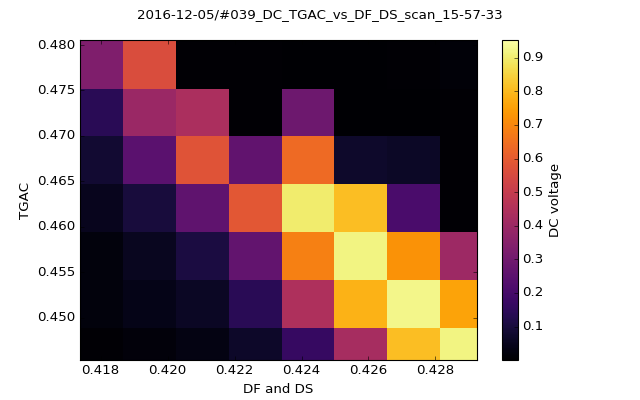

In [2]:
gate1 = TGAC
gate2 = DF_DS

gate1_vals = list(np.linspace(0.42,0.52, 20))
gate2_vals = list(np.linspace(0.41, 0.44, 20))

DC_parameter.setup()
data = qc.Loop(gate1[gate1_vals]
              ).loop(gate2[gate2_vals]
                    ).each(DC_parameter
                          ).then(qc.Task(layout.stop)
                                ).run(name='DC_{}_vs_{}_scan'.format(gate1.name, gate2.name),
                                      progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

# EPR measurements (no steering/ESR)
This is a calibration routine to find a point with high contrast (difference in signal between up state and down state). 
This measurement consists of three stages: empty, load, and read.
In the empty stage, the donor atom is ionized. 
It is then loaded with an electron in a random state.
Finally the state is read out for a long duration.
The contrast is found by looking if blips occured at the beginning of the read trace and at the end of the read trace.
The contrast is the difference in percentage of blips occuring at the beginning versus at the end.
The end part of the read trace is related to the number of dark counts, since we assume that an up-state electron will have had enough time to have tunneled off and on again.

## EPR - Parameter settings

In [3]:
EPR_parameter.pulse_sequence['read'].duration = 80

EPR_parameter.pulse_sequence

PulseSequence with 4 pulses, duration: 92
	DCPulse(empty, A=-1.5, t_start=0, t_stop=5)
	DCPulse(plunge, A=1.5, t_start=5, t_stop=10)
	DCPulse(read, A=0, t_start=10, t_stop=90)
	DCPulse(final, A=0, t_start=90, t_stop=92)

## EPR - Single point

In [ ]:
DF_DS(0.4215)
TGAC(0.4832)

In [ ]:
EPR_parameter.setup(samples=150, print_results=True)
EPR_parameter();

## EPR - 2D scan

In [4]:
DF_DS_vals = list(np.linspace(0.418, 0.429, 12))
TGAC_vals = list(np.linspace(0.445,0.48, 12))

In [5]:
EPR_parameter.setup(samples=150, t_read=20)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(EPR_parameter
                          ).run(name='EPR_calibration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-05/#040_EPR_calibration_16-12-01'
   <Type>   | <array_id>     | <array.name>   | <array.shape>
   Setpoint | TGAC_set       | TGAC           | (12,)
   Setpoint | DF_DS_set      | DF_DS          | (12, 12)
   Measured | fidelity_empty | fidelity_empty | (12, 12)
   Measured | fidelity_load  | fidelity_load  | (12, 12)
   Measured | fidelity_read  | fidelity_read  | (12, 12)
   Measured | up_proportion  | up_proportion  | (12, 12)
   Measured | dark_counts    | dark_counts    | (12, 12)
   Measured | contrast       | contrast       | (12, 12)
started at 2016-12-05 16:12:04


<IPython.core.display.Javascript object>


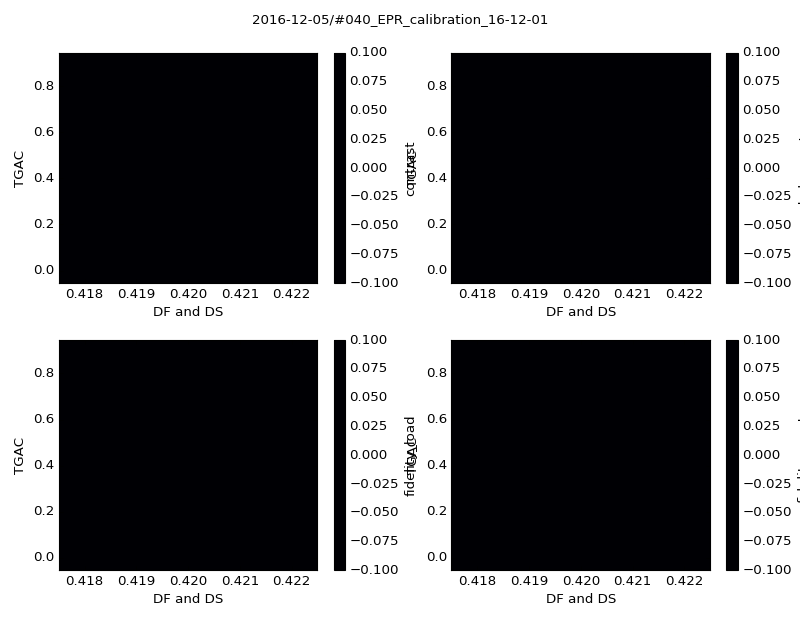

In [7]:
plot = CalibrationPlot(data)
#ax = plot.subplots[0]
#ax.qcodes_colorbar.set_clim(0, 0.4)

# Adiabatic sweep measurements

## Adiabatic - Parameter settings

In [169]:
    adiabatic_sweep_parameter.pulse_sequence['empty'].enabled = False

    adiabatic_sweep_parameter.pulse_sequence['plunge'].amplitude = 1.8
    adiabatic_sweep_parameter.pulse_sequence['plunge'].duration = 5

    adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].enabled = False
    adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].t_buffer = 30
    adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].t_no_blip = 90
    adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].t_max_wait = 400

    adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation=40e6
    adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.4
    adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].enabled = True
    adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].t_start = 4

    adiabatic_sweep_parameter.pulse_sequence['read'].duration=120

    adiabatic_sweep_parameter.setup(readout_threshold_voltage=readout_threshold_voltage)
    adiabatic_sweep_parameter(frequency_center)
    adiabatic_sweep_parameter.pulse_sequence

PulseSequence with 6 pulses, duration: 127
	DCPulse(plunge, A=1.8, t_start=0, t_stop=5)
	DCPulse(read, A=0, t_start=5, t_stop=125)
	FrequencyRampPulse(adiabatic_sweep, f_start=22350.00 MHz, f_stop=22390.00, A=None, t_start=4, t_stop=4.4)
	DCPulse(final, A=0, t_start=125, t_stop=127)
	
	Disabled pulses:
	DCPulse(empty, A=-1.5, t_start=0, t_stop=5)
	SteeredInitialization(steered_initialization, t_no_blip=90 ms, t_max_wait=400, t_buffer=30)

## Adiabatic - Center frequency scan

This code sweeps over the adiabatic sweep center frequency to find the ESR frequency.

To find the ESR frequency, use 28GHz * B0 as starting point, and search around that frequency.
Use a big initial frequency_deviation (around 60 MHz) and long duration (0.5 ms)
Once you see a spike in contrast, center around there and decrease both deviation and duration.

In [173]:
f_center = 22.385e9
f_span = 300e6
f_step = 10e6
adiabatic_sweep_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))
print('Sweep vals: {}'.format(len(adiabatic_sweep_vals)))

Sweep vals: 30


DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-05/#023_adiabatic_sweep_14-15-06'
   <Type>   | <array_id>          | <array.name>    | <array.shape>
   Setpoint | adiabatic_sweep_set | adiabatic_sweep | (30,)
   Measured | fidelity_load       | fidelity_load   | (30,)
   Measured | fidelity_read       | fidelity_read   | (30,)
   Measured | up_proportion       | up_proportion   | (30,)
   Measured | dark_counts         | dark_counts     | (30,)
   Measured | contrast            | contrast        | (30,)
started at 2016-12-05 14:15:11


<IPython.core.display.Javascript object>


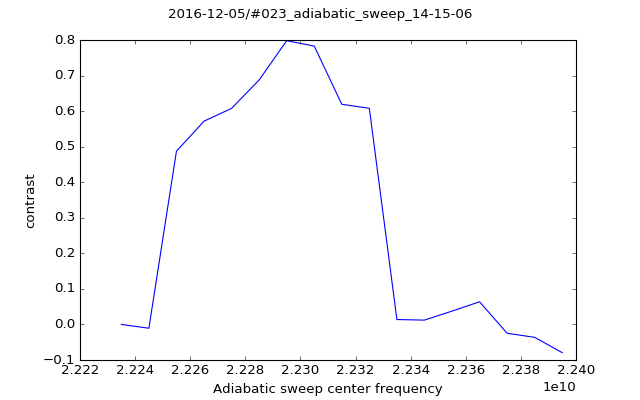

In [174]:
adiabatic_sweep_parameter.setup(samples=80, readout_threshold_voltage=readout_threshold_voltage)
data = qc.Loop(adiabatic_sweep_parameter[adiabatic_sweep_vals]
                     ).each(adiabatic_sweep_parameter
                           ).run(name='adiabatic_sweep',
                                progress_interval=True)
plot = qc.MatPlot(data.contrast, use_offset=False)

## Adiabatic - Single point

In [86]:
frequency_center=22.38e9

In [ ]:
TGAC(0.338)
DF_DS(0.478)

In [5]:
adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].enabled=True

In [87]:
adiabatic_sweep_parameter.setup(samples=450, readout_threshold_voltage=readout_threshold_voltage, 
                                print_results=True)
%time adiabatic_sweep_parameter();

fidelity_load: 0.000
fidelity_read: 0.619
up_proportion: 0.097
dark_counts: 0.080
contrast: 0.018
Wall time: 41.4 s


(0,
 0.61861666666666659,
 0.097065462753950338,
 0.079545454545454544,
 0.017520008208495794)

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18,5))

# Initialization buffers showing how long it takes before it starts plunging
plot_traces(steered_controller.initialization_traces(), ax=axes[0])
plt.title('Initialization trace\nOutput signal')

# Post initialization buffer showing if blips occurred or not
plot_traces(steered_controller.post_initialization_traces()['chA'], ax=axes[1])
plt.title('Post initialization buffer\nOutput signal')

# Post initialization buffer of arbstudio showing when it starts plunging
plot_traces(steered_controller.post_initialization_traces()['chB'], ax=axes[2])
plt.title('Post initialization buffer\nArbStudio signal')

# Post initialization buffer of arbstudio showing when it starts plunging
# plot_traces(adiabatic_sweep_parameter.data['acquisition_traces']['output'], ax=axes[3])
# plt.title('Readout trace\nOutput signal')

plt.tight_layout()

## Adiabatic - frequency deviation versus ESR duration
This is a 2D scan of frequency deviation versus duration.
From this measurement, the minimum acceptable values for frequency deviation and ESR duration can be extracted.

In [ ]:
pulse = adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep']
adiabatic_deviation_parameter = general_parameters.AttributeParameter(object=pulse, attribute='frequency_deviation')
adiabatic_duration_parameter = general_parameters.AttributeParameter(object=pulse, attribute='duration')

adiabatic_deviation_vals = list(np.logspace(5.5, 7.8, 8))
adiabatic_duration_vals = list(np.logspace(-2.7, -0.3, 8))

In [ ]:
adiabatic_sweep_parameter.pulse_sequence['read'].duration = 100
adiabatic_sweep_parameter.setup(samples=400)
adiabatic_sweep_parameter(frequency_center)
data = qc.Loop(adiabatic_deviation_parameter[adiabatic_deviation_vals]
              ).loop(adiabatic_duration_parameter[adiabatic_duration_vals]
                    ).each(adiabatic_sweep_parameter
                          ).run(name='adiabatic_deviation_vs_duration',
                                progress_interval=True)

In [ ]:
plot = qc.MatPlot(subplots=(1,2), figsize=(12,5), interval=10)
plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
# for ax in plot.subplots:
#     ax.set_xscale('log')
#     ax.set_yscale('log')
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Adiabatic - 2D scan

In [ ]:
TGAC_vals = list(np.linspace(0.475,0.5, 20))
DF_DS_vals = list(np.linspace(0.412, 0.423, 20))

In [ ]:
adiabatic_sweep_parameter.setup(samples=80, readout_threshold_voltage=readout_threshold_voltage,
                                save_traces=False)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(adiabatic_sweep_parameter
                          ).run(name='adiabatic_calibration',
                                progress_interval=True)

In [ ]:
plot = qc.MatPlot(subplots=(1,2), figsize=(12,5), interval=10)
ax = plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Dark counts
## Dark - Parameter settings

In [ ]:
dark_counts_parameter = measurement_parameters.dark_counts_parameter(layout=layout)

dark_counts_parameter.pulse_sequence['plunge'].enabled = False
dark_counts_parameter.pulse_sequence['adiabatic_sweep'].enabled = False

dark_counts_parameter.pulse_sequence['steered_initialization'].enabled = True
dark_counts_parameter.pulse_sequence['steered_initialization'].t_no_blip= 200
dark_counts_parameter.pulse_sequence['steered_initialization'].t_max_wait= 1000



dark_counts_parameter.pulse_sequence['read'].duration = 20

dark_counts_parameter.setup(readout_threshold_voltage, samples=20, print_results=True)
dark_counts_parameter.pulse_sequence

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18,5))

# Initialization buffers showing how long it takes before it starts plunging
plot_traces(steered_controller.initialization_traces(), ax=axes[0])
plt.title('Initialization trace\nOutput signal')

# Post initialization buffer showing if blips occurred or not
plot_traces(steered_controller.post_initialization_traces()['A'], ax=axes[1])
plt.title('Post initialization buffer\nOutput signal')

# Post initialization buffer of arbstudio showing when it starts plunging
plot_traces(steered_controller.post_initialization_traces()['C'], ax=axes[2])
plt.title('Post initialization buffer\nArbStudio signal')

# Post initialization buffer of arbstudio showing when it starts plunging
plot_traces(adiabatic_sweep_parameter.traces['output'], ax=axes[3])
plt.title('Readout trace\nOutput signal')

plt.tight_layout()

## Dark - Single point

In [ ]:
EPR_parameter.setup(samples=150, print_results=True)
EPR_parameter();

# Read level sweep (to be fixed)

In [ ]:
variable_read_parameter.setup(samples=100)
data = qc.Loop(variable_read_parameter[-1.5:2.5:0.04]
                     ).each(variable_read_parameter
                           ).run(name='variable_read',
                                progress_interval=True)

In [ ]:
plotQ = qc.QtPlot()
plotQ.add(data.Channel_A_signal)

plotQ = qc.QtPlot()
plotQ.add(data.Channel_C_signal)

# T1 measurement

## T1 - Parameter settings

In [ ]:
T1_parameter = measurement_parameters.T1_Parameter(layout=layout)

T1_parameter.pulse_sequence['empty'].enabled = False
T1_parameter.pulse_sequence['steered_initialization'].enabled = True
T1_parameter.pulse_sequence['steered_initialization'].t_buffer = 30
T1_parameter.pulse_sequence['steered_initialization'].t_no_blip = 120
T1_parameter.pulse_sequence['steered_initialization'].t_max_wait = 500
T1_parameter.pulse_sequence['adiabatic_sweep'].enabled = True
T1_parameter.pulse_sequence['adiabatic_sweep'].frequency_center=frequency_center
T1_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation=10e6
T1_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.2
T1_parameter.pulse_sequence['adiabatic_sweep'].t_start = 4
T1_parameter.pulse_sequence['plunge'].amplitude = 1.8
T1_parameter.pulse_sequence['plunge'].duration = 5
T1_parameter.pulse_sequence['read'].duration = 40
setup_T1 = partial(T1_parameter.setup, readout_threshold_voltage, samples=80,
                   save_traces=True)
setup_T1()

In [ ]:
# Additional parameter setups

# PR
adiabatic_sweep_parameter.pulse_sequence['empty'].enabled = False
adiabatic_sweep_parameter.pulse_sequence['plunge'].amplitude = 1.8
adiabatic_sweep_parameter.pulse_sequence['plunge'].duration = 5
adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].enabled = True
adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].t_buffer = 30
adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].t_no_blip = 120
adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].t_max_wait = 500
adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation=10e6
adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.2
adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].enabled = True
adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].t_start = 4
adiabatic_sweep_parameter.pulse_sequence['read'].duration=120
setup_LR = partial(adiabatic_sweep_parameter.setup, readout_threshold_voltage, samples=250,
                  save_traces=True)
setup_LR()

# dark counts
dark_counts_parameter = measurement_parameters.dark_counts_parameter(layout=layout)
dark_counts_parameter.pulse_sequence['plunge'].enabled = False
dark_counts_parameter.pulse_sequence['adiabatic_sweep'].enabled = False
dark_counts_parameter.pulse_sequence['steered_initialization'].enabled = True
dark_counts_parameter.pulse_sequence['steered_initialization'].t_no_blip = 200
dark_counts_parameter.pulse_sequence['steered_initialization'].t_max_wait = 1000
dark_counts_parameter.pulse_sequence['steered_initialization'].t_buffer = 30
dark_counts_parameter.pulse_sequence['read'].duration = 40
setup_dark_counts = partial(dark_counts_parameter.setup, readout_threshold_voltage, samples=250,
                            save_traces=True)
setup_dark_counts()

## T1 - Single point

In [ ]:
T1_parameter(10000)
T1_parameter.print_results = True
%time up_proportion,number_traces_loaded = T1_parameter()

## T1 - single scan

In [ ]:
# Calculate T1 durations
T1_wait_times = list(np.logspace(1, 3, num=10, base=10))

# Shuffle times
#np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

In [ ]:
# Single T1 sweep

data = qc.Loop(T1_parameter[T1_wait_times]
                     ).each(T1_parameter
                           ).run(name='T1_single_sweep')

plotQ = qc.MatPlot()
plotQ.add(data.up_proportion)

## T1 - Multiple scans

In [6]:
# Calculate T1 durations (shuffled)
T1_wait_times = list(np.logspace(1, 4, num=12, base=10))
#np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [10.0, 18.738174228603839, 35.111917342151308, 65.793322465756788, 123.28467394420659, 231.01297000831579, 432.87612810830569, 811.13083078968725, 1519.9110829529332, 2848.0358684357989, 5336.6992312063076, 10000.0]


In [7]:
data = qc.Loop(dummy_parameter[0:30:1]
              ).each(qc.Task(setup_LR),
                     adiabatic_sweep_parameter,
                     qc.Task(setup_dark_counts),
                     dark_counts_parameter,
                     qc.Task(setup_T1),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter)
                    ).run(name='T1_data', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-02/#036_T1_data_21-57-51'
   <Type>   | <array_id>              | <array.name>      | <array.shape>
   Setpoint | dummy_set               | dummy             | (30,)
   Measured | fidelity_load           | fidelity_load     | (30,)
   Measured | fidelity_read           | fidelity_read     | (30,)
   Measured | up_proportion_1_2       | up_proportion     | (30,)
   Measured | dark_counts             | dark_counts       | (30,)
   Measured | contrast                | contrast          | (30,)
   Measured | up_proportion_3_0       | up_proportion     | (30,)
   Measured | num_traces_loaded_3_1   | num_traces_loaded | (30,)
   Setpoint | T1_wait_time_set        | T1_wait_time      | (30, 12)
   Measured | up_proportion_5_0_0     | up_proportion     | (30, 12)
   Measured | num_traces_loaded_5_0_1 | num_traces_loaded | (30, 12)
started at 2016-12-02 21:57:55


<IPython.core.display.Javascript object>


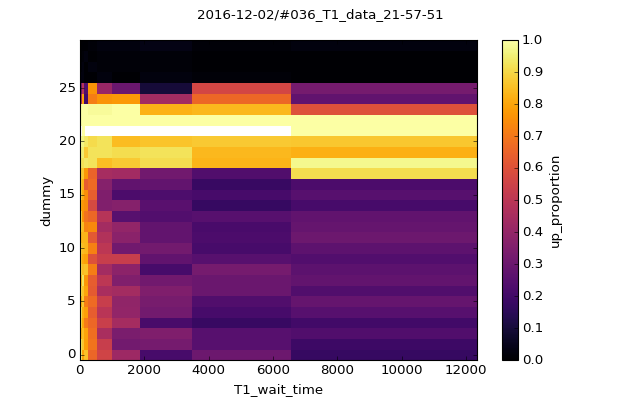

In [8]:
plotQ = qc.MatPlot()
plotQ.add(data.up_proportion_5_0_0)

## T1 - plunge voltage scan
This scan measures the contrast for a

In [ ]:
T1_parameter.pulse_sequence['steered_initialization'].enabled = False

T1_parameter.pulse_sequence['plunge'].amplitude = 1.8

T1_parameter.pulse_sequence['adiabatic_sweep'].enabled = True
T1_parameter.pulse_sequence['adiabatic_sweep'].frequency_center=frequency_center
T1_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation=10e6
T1_parameter.pulse_sequence['adiabatic_sweep'].t_start=1
T1_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.2

T1_parameter.pulse_sequence['read'].duration = 20

T1_parameter.setup(readout_threshold_voltage, samples=350)
T1_parameter.pulse_sequence

In [ ]:
pulse = T1_parameter.pulse_sequence['plunge']
plunge_voltage_parameter = general_parameters.AttributeParameter(object=pulse, attribute='voltage')

In [ ]:
T1_parameter(4000)
data = qc.Loop(plunge_voltage_parameter[1:2.5:0.1]
              ).each(qc.Task(T1_parameter.setup),
                     T1_parameter
                    ).run(name='T1_data', progress_interval=True)

In [ ]:
qc.MatPlot(data.up_proportion)

## T1 analysis

In [ ]:

T1_msmt = T1_Measurement(B0=1.2, location='2016-11-24/#006_T1_data_12-19-40')
T1_msmt.plot_T1()
print(T1_msmt.fit_result.fit_report())

In [ ]:
#data.arrays['up_proportion']
data.T1_wait_time_set[0]

In [ ]:
# Continuous T1 sweep
setup_ELRLR = partial(ELRLR_parameter.setup, samples=400, data_manager=data_manager_raw)
setup_T1 = partial(T1_parameter.setup, threshold_voltage=readout_threshold_voltage, samples=150, data_manager=data_manager_raw)
setup_ELRLR()
setup_T1()
data = qc.Loop(dummy_param[0:30:1]
              ).each(qc.Task(setup_ELRLR),
                     ELRLR_parameter,
                     qc.Task(setup_T1),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter)
                    ).run(name='T1_data', progress_interval=True)

# plotQ = qc.QtPlot()
# plotQ.add(data.up_proportion)

In [ ]:
data.sync()
print(data.T1_wait_time_set[0])
data.up_proportion_3_0_0[29]

# Notes

To save individual traces when performing a measurement, set:
    
EPR_parameter.setup(samples=100, data_manager=data_manager_raw)

In [ ]:
steered_initialization = adiabatic_sweep_parameter.pulse_sequence['steered_initialization']

In [ ]:
adiabatic_sweep_parameter.pulse_sequence['load'].t_stop=15

In [ ]:
adiabatic_sweep_parameter.steered_initialization

In [ ]:
steered_controller.record_initialization_traces

To enable/disable steered initialization, use:

adiabatic_sweep_parameter.steered_intialization = True/False

This adds/removes the steered initialization "pulse" from the EPR_parameter.pulse_sequence
If steered_initialization is enabled, you can access and modify its properties via

steered_initialization = adiabatic_sweep_parameter.pulse_sequence['steered_initialization']

Note that steered initialization is currently only implemented for the adiabatic sweep, but is easy to add for other parameters, such as T1_parameter (just add the pulse)

steered_controller is the acquisition controller specifically for steered initialization
You can look at the initialization traces when using steered initialization.

First set the flag 
steered_controller.record_initialization_traces(True)

The initialization traces can then be accessed
steered_controller.initialization_traces()

You can also look at the first buffer after the pulseblaster.start() command has been set via
steered_controller.post_initialization_traces()
This can be useful for checking the delay between sending the command and plunging

To setup a parameter where steered initialization is enabled, you must pass it a readout threshold voltage every time.

adiabatic_sweep_parameter.setup(readout_threshold_voltage=threshold_voltage)

This threshold voltage can be obtained from an EPR scan (see T1_measurement):

EPR_parameter.setup(samples=30)
EPR_parameter()
traces_read = EPR_parameter.trace_segments['output']['read']
_, _, readout_threshold_voltage = analysis.find_high_low(traces_read)

In [ ]:
adiabatic_sweep_parameter.pulse_sequence.add(adiabatic_sweep_parameter._steered_initialization)
adiabatic_sweep_parameter.pulse_sequence.remove(adiabatic_sweep_parameter._steered_initialization)

To save raw traces, use:

EPR_parameter.setup(save_traces=True, data_manager=data_manager_raw)